In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 200)
pd.set_option("display.colheader_justify", "center")

# EDA Packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)

# ML Packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In this notebook, I will provide some exploratory data analysis of the UNSW NBB15 PCAP data, publically available here: https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/

Here is the data description taken from the link above: 

"The raw network packets of the UNSW-NB 15 dataset was created by the IXIA PerfectStorm tool in the Cyber Range Lab of the Australian Centre for Cyber Security (ACCS) for generating a hybrid of real modern normal activities and synthetic contemporary attack behaviours.

Tcpdump tool is utilised to capture 100 GB of the raw traffic (e.g., Pcap files). This dataset has nine types of attacks, namely, Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms. The Argus, Bro-IDS tools are used and twelve algorithms are developed to generate totally 49 features with the class label."

Importing feature description csv

In [2]:
feature_desc = pd.read_csv("https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/NUSW-NB15_features.csv",
                           encoding= 'unicode_escape',
                          index_col = False)

In [3]:
feature_desc

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,"Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR, REQ, RST, TST, TXD, URH, URN, and (-) (if not used state)"
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


The featues above (with the exception of the final two, the attack type and binary label) are what we plan to use to train a classifier.  I have little understanding of these features, which is why I need your feedback (Alejandro, looking at you).

* Are these features likely to be available from the haven/saber PCAP data?
* For the categorical features, is there any ordinal nature to the categories?  For example, a city's size can be categorized as small, medium and large, where large > medium > small.
* Is there one attack type that should be our focus (Fuzzers, Analysis, etc.)?

Any other feedback would be greatly appreciated!

For a more detailed explanation of the attacks in this database: https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/NUSW-NB15_GT.csv

The code below reads in the first 3 rows of the attack description

In [4]:
pd.read_csv('https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/NUSW-NB15_GT.csv',
           nrows = 3)

,Start time,Last time,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.
0,1421927414,1421927416,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.nsf (https://strikecenter.bpointsys.com/bps/strikes/recon/http/domino/access_domino_doladmin_nsf.xml),-,.
1,1421927415,1421927415,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (https://strikecenter.bpointsys.com/bps/strikes/exploits/rservices/solaris_rwall_format_string.xml),CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cvename.cgi?name=2002%2d0573)BID 4639 (http://www.securityfocus.com/bid/4639)CVSS-High (https://strikecenter.bpointsys.com/bps/reference/CVSS/7.5%20%28A...,.
2,1421927416,1421927416,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Execution [009] (https://strikecenter.bpointsys.com/bps/strikes/exploits/browser/wmf_009.xml),CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cvename.cgi?name=2005%2d4560)BID 16074 (http://www.securityfocus.com/bid/16074)OSVDB 21987 (http://www.osvdb.org/21987)CVSS-High (https://strikecenter.b...,.


The website also provides a train/test split for evaulating classifiers.  We will do some EDA with the train data, train a simple classifier (random forest) and evaluate its performance on the test data.

In [5]:
unsw_train = pd.read_csv('https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv')

unsw_train[unsw_train.select_dtypes('object').columns] = unsw_train.select_dtypes('object').apply(lambda x: x.astype('category'))
unsw_train['label'] = unsw_train['label'].astype('category')

In [6]:
unsw_train.head(5)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


## Visualizing Features

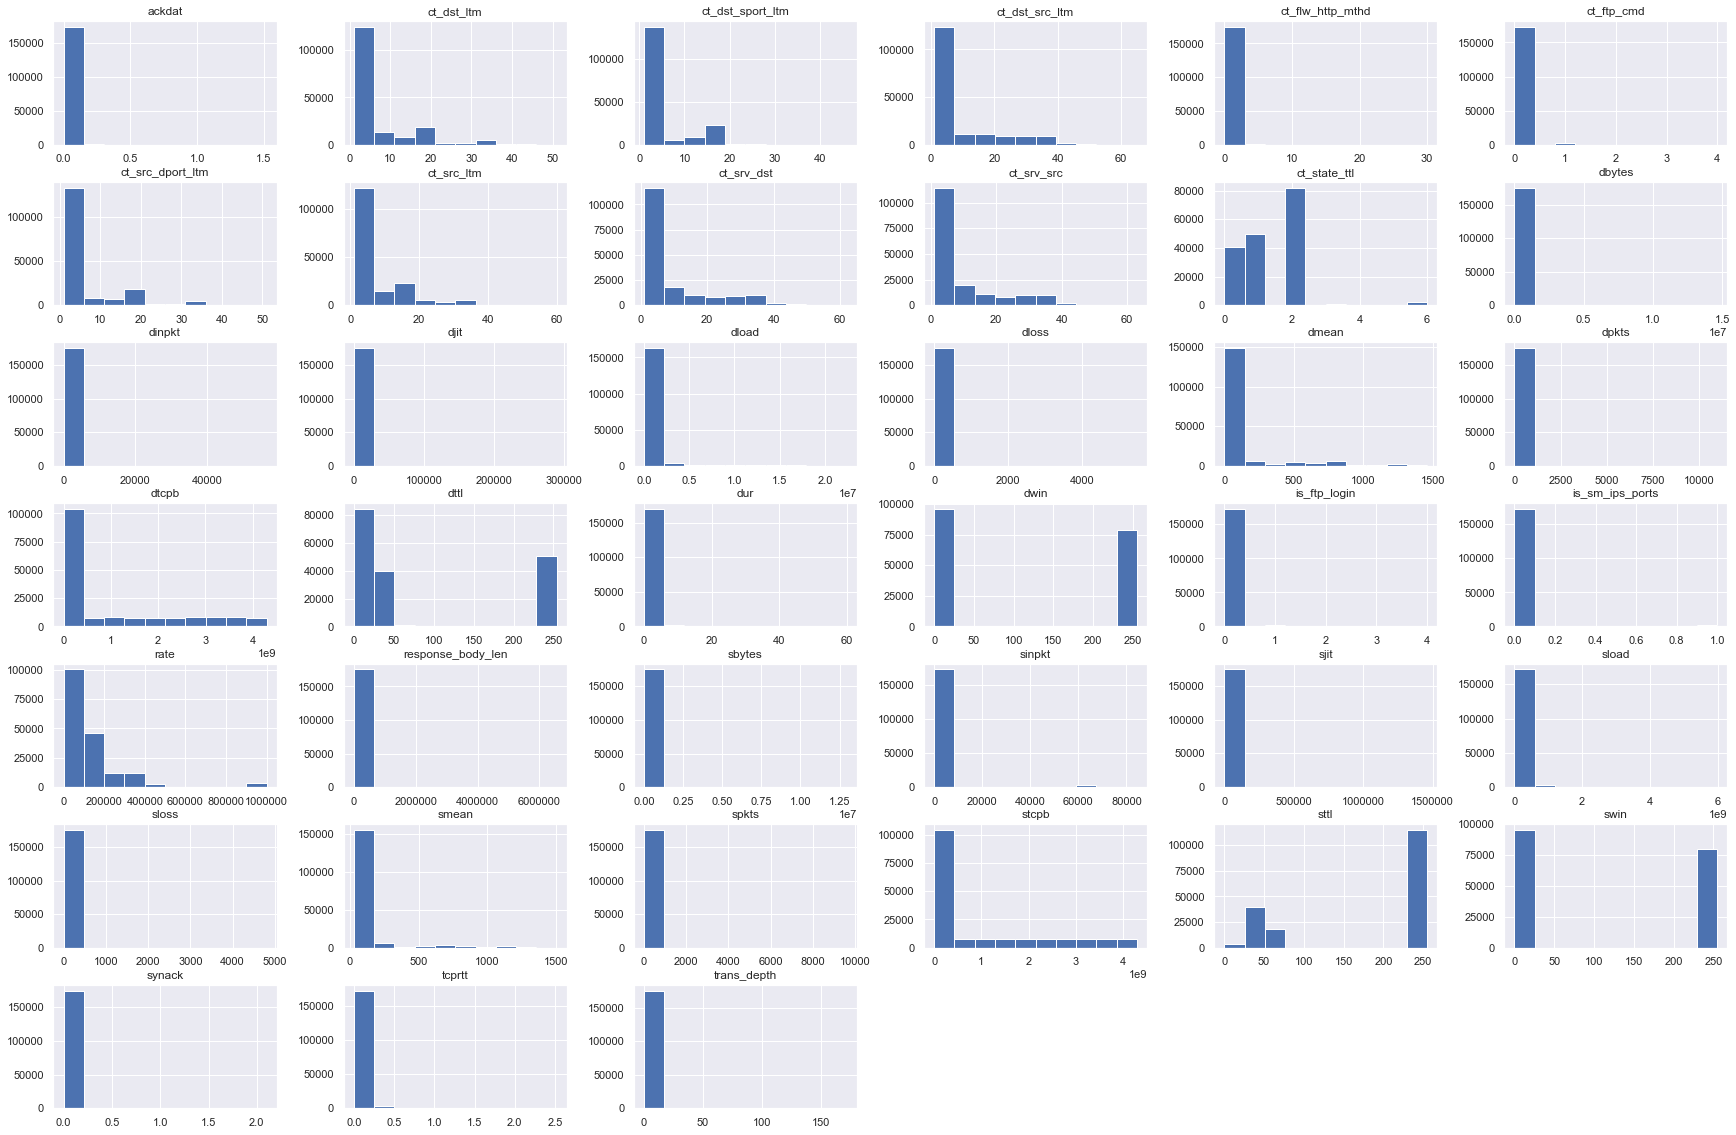

In [7]:
unsw_train.drop('id', axis=1).hist(figsize=(30,20));

Many of the features appear to have mostly 0's.  For example:

In [8]:
unsw_train['synack'].describe()

count    175341.000000
mean          0.021020
std           0.043400
min           0.000000
25%           0.000000
50%           0.000000
75%           0.023268
max           2.100352
Name: synack, dtype: float64

To reduce the dimensionality of this feature space, we could consider dichotomizing many variables (0: 0, 1: > 0).  We could use traditional dimensionality reduction techniques such as Principle Components Analysis (PCA).  Moreover, we may consider feature selection techniques that encourage model sparsity via regularization, such as Ridge Regression

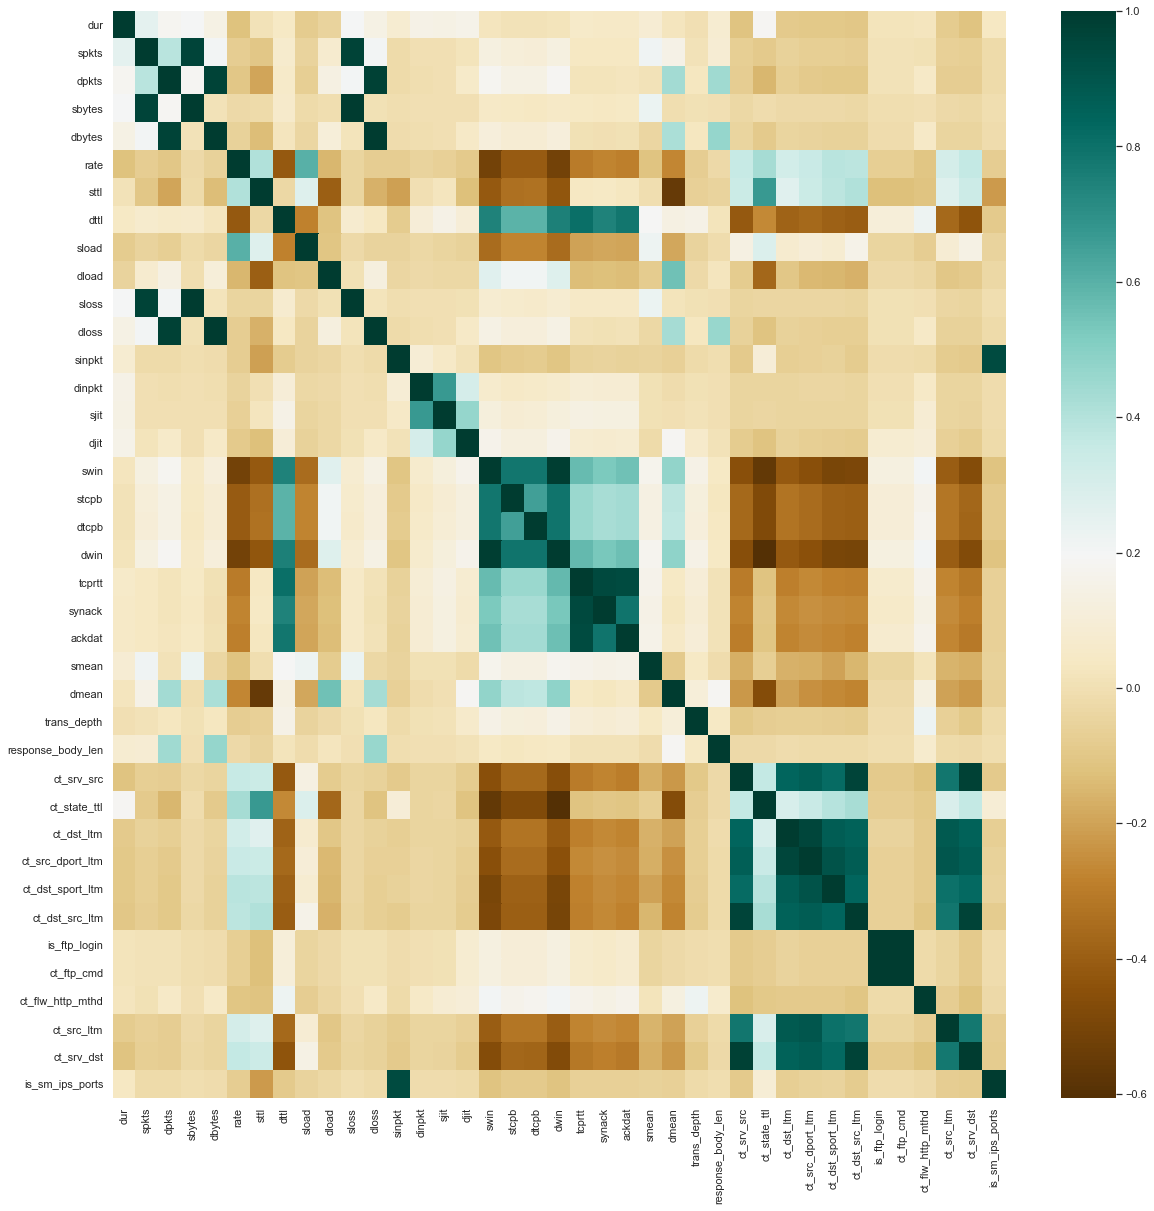

In [9]:
plt.figure(figsize=(20,20))
c= unsw_train.drop(['id', 'label', 'attack_cat'], axis=1).corr()
sns.heatmap(c,cmap='BrBG',annot=False);

The heatmap above allows us to visualize the correlation between the features of our dataset.  The darker squares reflect stronger associations (linear relationships) between the corresponding features.  Some relationships between features can be understood given the variable definitions, e.g. "number of connections ..." features.  This is more evidence that a subset of all features may be sufficient for classifying attack/benign.

In [10]:
float_cols = list(unsw_train.columns[unsw_train.dtypes == 'float'])
float_cols.append('label')

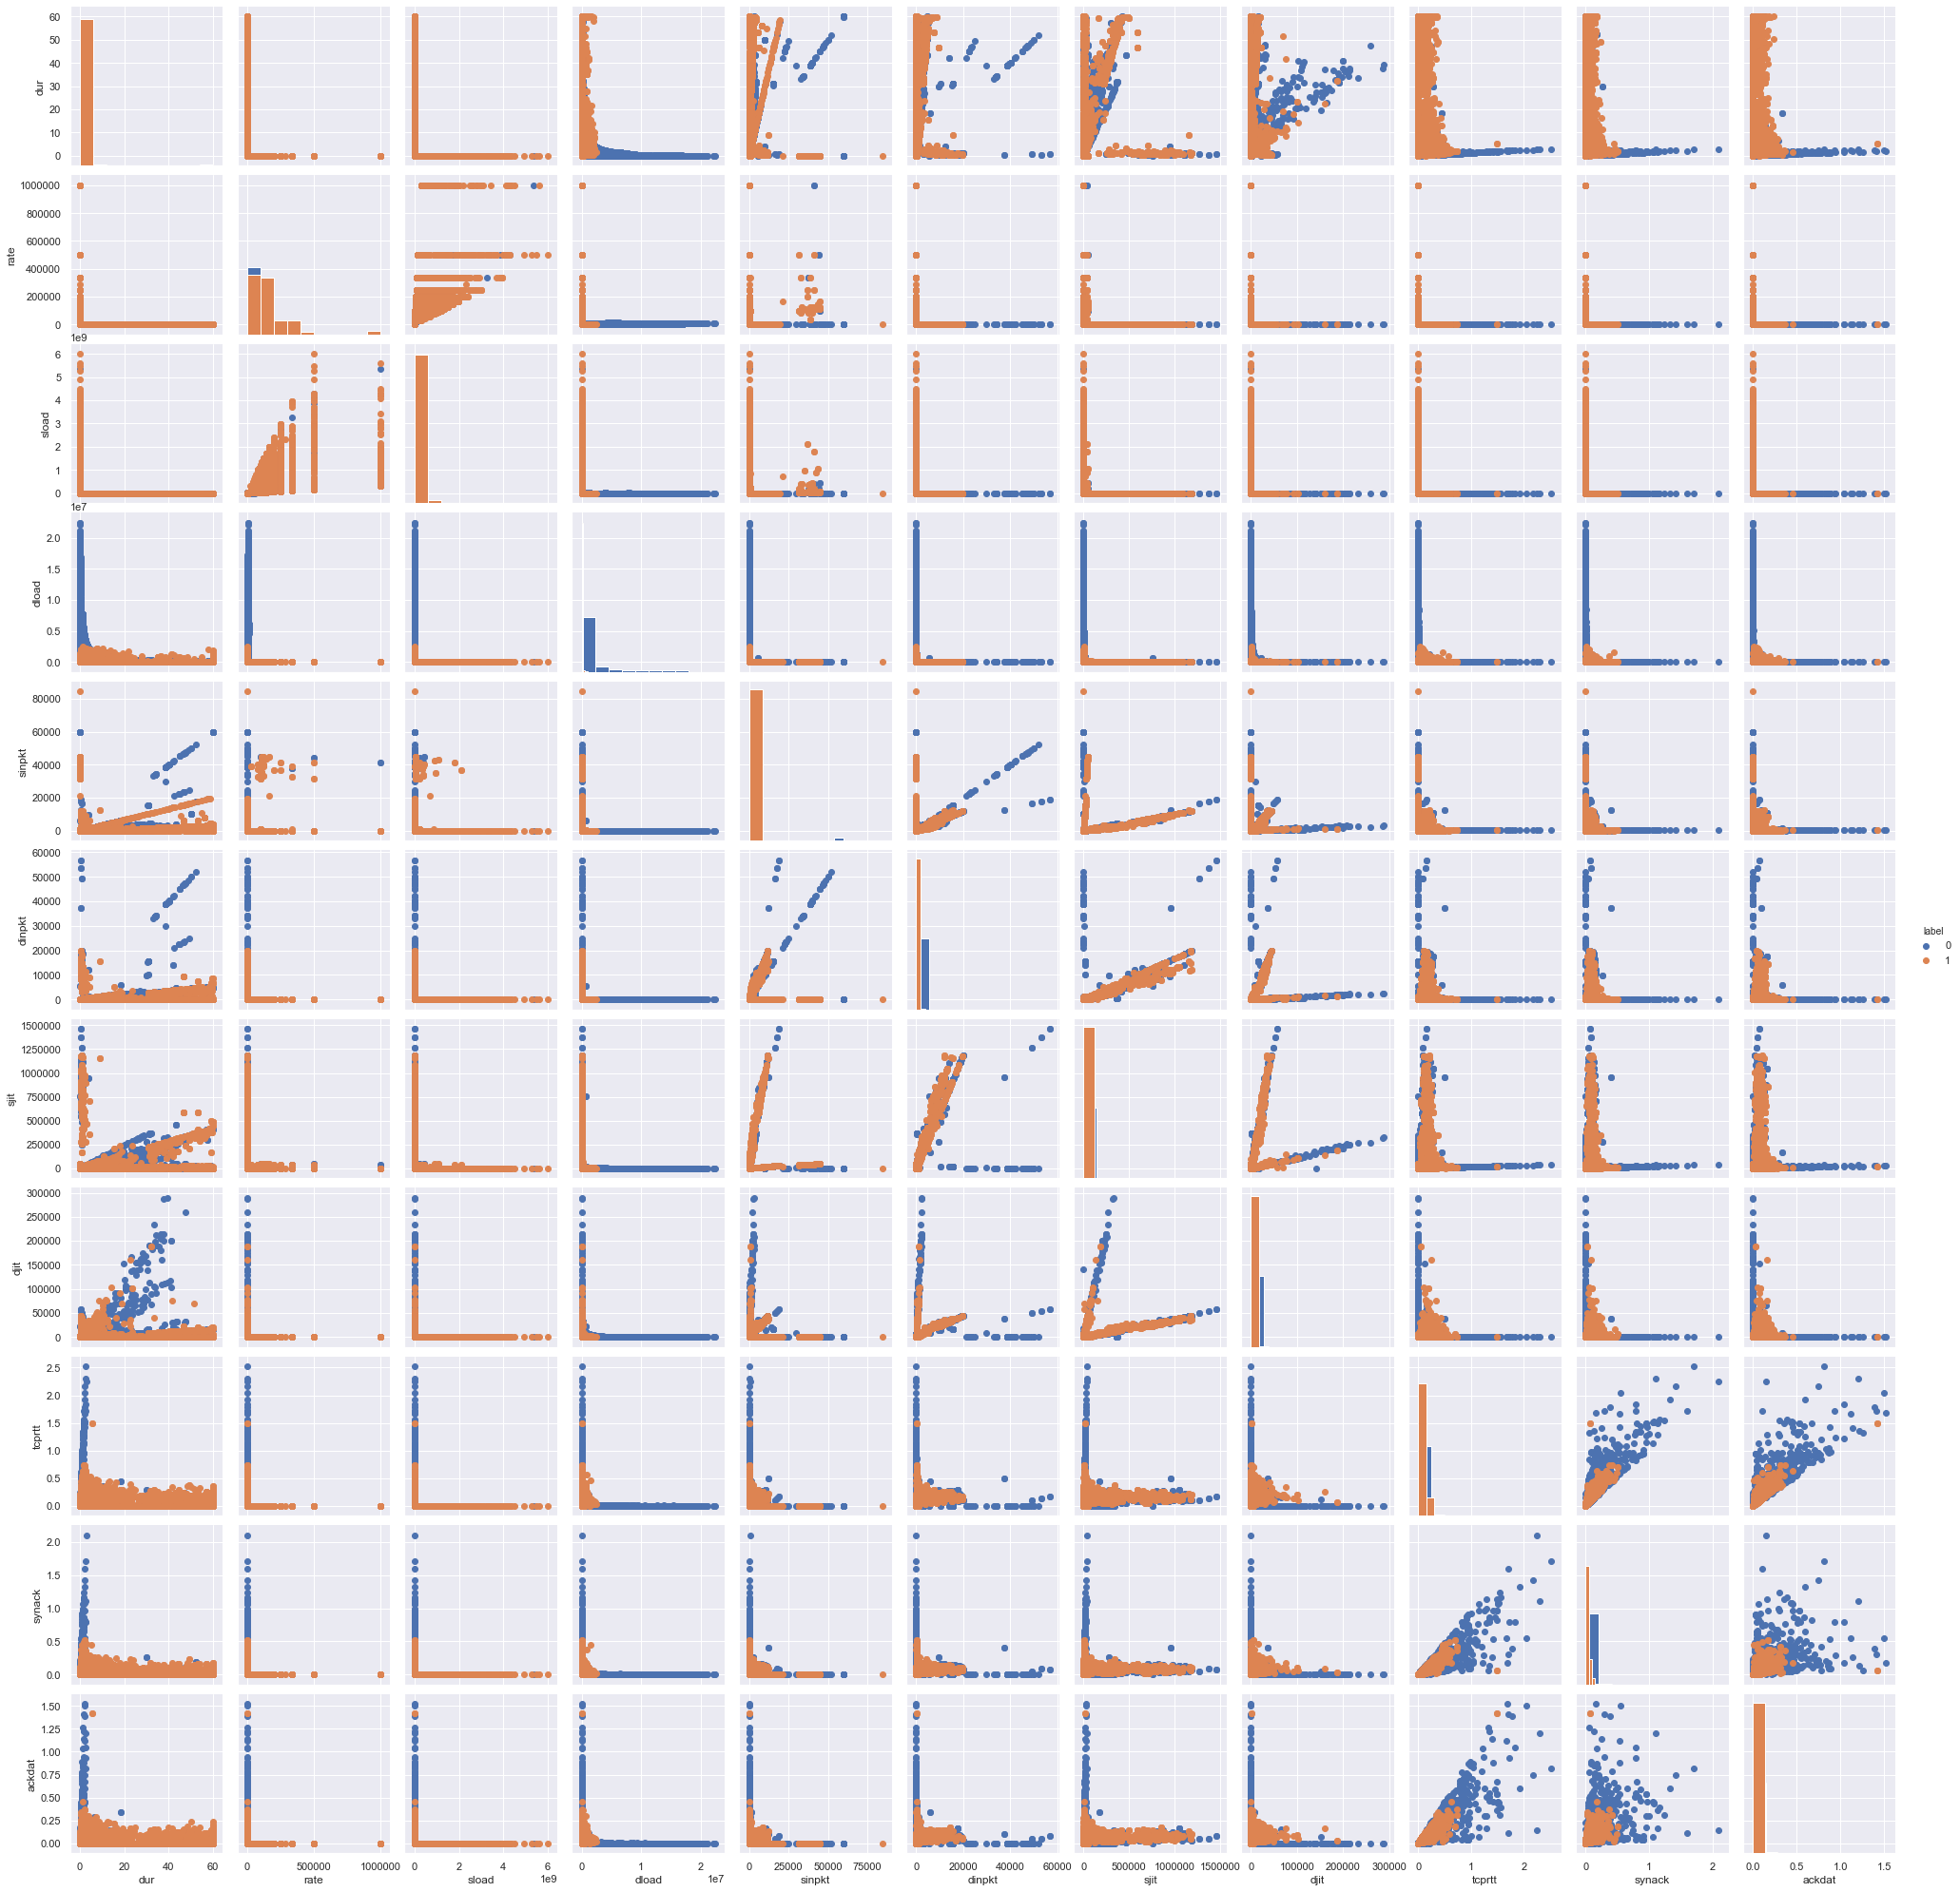

In [11]:
g = sns.PairGrid(unsw_train.loc[:,float_cols], hue='label')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

The pairplots of floating point features, colored by label (attack/benign), suggest some class separability that we could leverage when training a classifier.

## Training a binary classifier

We will now train a random forest classifer and evaluate its peformance on the UNSW test dataset.

In [12]:
(unsw_train.shape[1] - 2)**0.5

6.557438524302

We will consider 7 features at each tree split

In [13]:
unsw_train['label'].value_counts() / len(unsw_train)

1    0.680622
0    0.319378
Name: label, dtype: float64

In [15]:
round((sum(np.random.randint(0,2,175341) == unsw_train['label']) / len(unsw_train)), 3)

0.499

By random guess, we would identify about 50% of attacks.  Lets compare this to random forest

Reading in the test dataset from the UNSW website

In [16]:
unsw_test = pd.read_csv('https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv')

unsw_test['label'] = unsw_test['label'].astype('category')
unsw_test[unsw_test.select_dtypes('object').columns] = unsw_test.select_dtypes('object').apply(lambda x: x.astype('category'))

In [17]:
random_forest_1 = RandomForestClassifier(max_depth=3, random_state=35, max_features=7)
random_forest_1.fit(unsw_train.select_dtypes(['float', 'int']).drop('id', axis=1), unsw_train['label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=35, verbose=0,
                       warm_start=False)

Evaluating on test set

In [18]:
rf_predict = random_forest_1.predict(unsw_test.select_dtypes(['float', 'int']).drop('id', axis=1))

In [19]:
print(classification_report(unsw_test['label'], rf_predict))

              precision    recall  f1-score   support

           0       1.00      0.48      0.65     37000
           1       0.70      1.00      0.83     45332

    accuracy                           0.77     82332
   macro avg       0.85      0.74      0.74     82332
weighted avg       0.84      0.77      0.75     82332



With little hyperparameter tuning and feature engineering, only using the continuous features, we were able to attain ~77% accuracy.  However, judging by the high precision and low recall, we are still generating false-positives at an unacceptable level.

Next steps:

* discuss features used in this model, potential feature engineering
    - dimensionality reduction 
* tune hyperparameters to improve random forest model performance
    - number of features considered at each split
    - tree depth
    - number of models in the ensemble
* assess other ML algorithm performance
    - SVM
    - XGBoost
    - Penalized Logistic Regression